# Data Prepration

For every image, get same number of instances and non instance sections

- Strech images or pad images?
- or experiment with both?
- should I crop or keep only the segmented image?
    - crop

## Step 1: Getting all instances

In [1]:
import cv2
import json
import os
import matplotlib.pyplot as plt

In [2]:
kili = json.load(open("../KILI_COCO/annotations.json", "r"))
full = json.load(open("../full_annotations.json"))

Annotation format: cx, cy, width, height

In [6]:
kili["annotations"][0]

{'iscrowd': 0,
 'image_id': 1,
 'bbox': [0.6937950849533081,
  0.17073695361614227,
  0.017922647297382355,
  0.011738809756934643],
 'segmentation': [],
 'category_id': 2,
 'id': 1,
 'area': 0}

In [9]:
full["annotations"][0]

{'iscrowd': 0,
 'image_id': 1,
 'bbox': [877.0, 119.0, 23.0, 8.0],
 'segmentation': [],
 'category_id': 2,
 'id': 1,
 'area': 184}

To crop images we will get squares with cx, cy, max(width, height), max(width, height)

In [12]:
counter_w = {}
counter_h = {}

for annotation in full["annotations"]:
    if len(annotation["bbox"]) == 4:
        _, _, w, h = annotation["bbox"]
        counter_w[w] = counter_w.get(w, 0) + 1
        counter_h[h] = counter_h.get(h, 0) + 1

(array([154.,  71.,  36.,  37.,  27.,  16.,   9.,  11.,   8.,   5.,   4.,
          4.,   2.,   2.,   1.,   0.,   0.,   0.,   0.,   1.]),
 array([1.0000e+00, 1.5720e+02, 3.1340e+02, 4.6960e+02, 6.2580e+02,
        7.8200e+02, 9.3820e+02, 1.0944e+03, 1.2506e+03, 1.4068e+03,
        1.5630e+03, 1.7192e+03, 1.8754e+03, 2.0316e+03, 2.1878e+03,
        2.3440e+03, 2.5002e+03, 2.6564e+03, 2.8126e+03, 2.9688e+03,
        3.1250e+03]),
 <BarContainer object of 20 artists>)

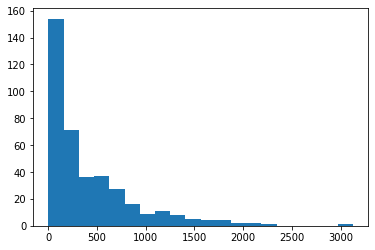

In [17]:
plt.hist(counter_h.keys(), bins=20)

(array([123., 107.,  62.,  38.,  29.,  15.,  14.,   8.,   7.,   7.,   2.,
          3.,   4.,   3.,   3.,   1.,   0.,   1.,   1.,   2.]),
 array([1.0000e+00, 1.2330e+02, 2.4560e+02, 3.6790e+02, 4.9020e+02,
        6.1250e+02, 7.3480e+02, 8.5710e+02, 9.7940e+02, 1.1017e+03,
        1.2240e+03, 1.3463e+03, 1.4686e+03, 1.5909e+03, 1.7132e+03,
        1.8355e+03, 1.9578e+03, 2.0801e+03, 2.2024e+03, 2.3247e+03,
        2.4470e+03]),
 <BarContainer object of 20 artists>)

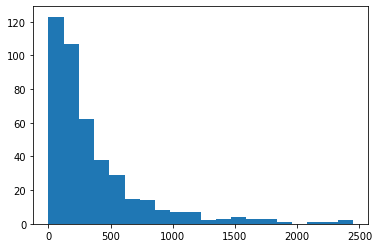

In [16]:
plt.hist(counter_w.keys(), bins=20)

Getting number of instances of each category

In [3]:
counter_cat = {}
for annotation in kili["annotations"]:
    counter_cat[annotation["category_id"]] = counter_cat.get(annotation["category_id"], 0) + 1
    
counter_cat

{2: 3763, 1: 7915, 3: 1737, 0: 1502}

Based on the images found, we will keep them to size 32x32 for every image, with crop on max dimension

Creating a pipeline for that

A generator object for giving image and corresponding bounding boxes with categories

In [186]:
kili["annotations"][0]

{'iscrowd': 0,
 'image_id': 1,
 'bbox': [0.6937950849533081,
  0.17073695361614227,
  0.017922647297382355,
  0.011738809756934643],
 'segmentation': [],
 'category_id': 2,
 'id': 1,
 'area': 0}

In [4]:
def getImageData(data):
    
    image_id = 0
    annotation_id = 0
    image_data = {"path": "", "bbox": [], "height": 0, "width": 0}    
    
    while image_id < len(data["images"]):

        path = data["images"][image_id]["file_name"]
        
        while annotation_id < len(data["annotations"]) and data["annotations"][annotation_id]["image_id"] == data["images"][image_id]["id"]:
            bbox = data["annotations"][annotation_id]["bbox"]
            if (len(bbox) == 4 
                and bbox[2]*data["images"][image_id]["width"] > 32 
                and bbox[3]*data["images"][image_id]["width"] > 32):
                yield {
                    "path": path,
                    "height": data["images"][image_id]["height"],
                    "width": data["images"][image_id]["width"],
                    "bbox": bbox,
                    "category": data["annotations"][annotation_id]["category_id"]
                }
            annotation_id += 1
                
        image_id += 1

In [20]:
def preprocessImage(imageData, folder="../KILI_COCO/", padding=10, imsize=64):
    img = cv2.imread(os.path.join(folder, imageData["path"]))
    cx, cy, w, h = imageData["bbox"]
    cx, cy, w, h = (int(cx*imageData["width"]),
                    int(cy*imageData["height"]),
                    int(w*imageData["width"]),
                    int(h*imageData["height"]))
    
    max_d = max(w, h) 
    
    x = cx - max_d//2 - padding
    y = cy - max_d//2 - padding

    x, y = max(0, x), max(0, y)    
    
    img = img[y:y+max_d+padding, x:x+max_d+padding, :]
    img = cv2.resize(img, (imsize, imsize), interpolation = cv2.INTER_CUBIC)
    return img
    # return img[y:y+h, x:x+w, :]

In [22]:
def imageWriter(i=0):
    
    i = i
    category_map = {}
    
    def writer(image, category):
        nonlocal i
        if int(category) in [0, 1, 2]:
            cv2.imwrite(f"./dataset5/plastic/{i}.jpg", img)
        else:
            cv2.imwrite(f"./dataset5/not_plastic/{i}.jpg", img)
        category_map[i] = category
        i = i + 1
        
    def category_writer():
        json.dump(category_map, open("./dataset5/info.json", "w"))
    
    return writer, category_writer

In [23]:
img_write, info_write = imageWriter()

for idx, img_data in enumerate(getImageData(kili)):
    
    img = preprocessImage(img_data)
    
    img_write(img, img_data["category"])
    
    print(f"Image {idx}", end="\r")
    # if idx==10:
    #     break
        
# info_write()

In [220]:
counter_cat[0]+counter_cat[1]+counter_cat[2] - counter_cat[3]

11443

generate around 11443 non plastic images

In [230]:
img_data, kili["images"][0]

({'path': 'batch_10/004258.jpg',
  'height': 720,
  'width': 1280,
  'bbox': [0.2213168740272522,
   0.6254871487617493,
   0.028013726696372032,
   0.024340568110346794],
  'category': 1},
 {'height': 720, 'width': 1280, 'id': 1, 'file_name': 'batch_1/000001.jpg'})

In [251]:
# !pip install more-itertools

In [9]:
from more_itertools import peekable

In [10]:
from random import randint

In [283]:
randint(1, 10)

1

Instead of generating random 64x64 patches, generate random sized patches then save them to 64x64, similar to real scenario of images with and IOU threshold of 0.3

In [13]:
def generatePatches(height, width, bboxes, n=2, imsize=64, iou_thresh=0.3):
    
    # to pixels
    bboxes_px = []
    for bbox in bboxes:
        bboxes_px.append([
            int(bbox[0]*width),
            int(bbox[1]*height),
            int(bbox[2]*width),
            int(bbox[3]*height),
        ])
        
    # random generation
    patches = []
    while len(patches) < n:
        rh, rw = randint(64, 600), randint(64, 600)
        crx, cry = randint(0, height-rw), randint(0, width-rh)
        
        intersects = False
        # check if intersection
        for bbox in bboxes_px:
            
            x_overlap = abs(crx - bbox[0]) - rw//2 - imsize//2
            y_overlap = abs(cry - bbox[1]) - rh//2 - imsize//2
            
            try:
                iou = (x_overlap*y_overlap)/(rh*rw + imsize**2 - x_overlap*y_overlap)
            except:
                intersects = True
                break
            
            if iou > iou_thresh:
                intersects = True
                break
            
            # if abs(crx - bbox[0]) < imsize or abs(cry - bbox[1]) < imsize:
            #     intersects = True
            #     break
        
        if intersects == False:
            patches.append([crx, cry, rw, rh])
    
    return patches

In [14]:
len(os.listdir("./dataset5/not_plastic/")), len(os.listdir("./dataset5/plastic/"))

(677, 3883)

In [25]:
len(os.listdir("./dataset5/not_plastic/")) + len(os.listdir("./dataset5/plastic/"))

5726

The dataset is imbalanced to make it balances we will take patches on images from regions not having plastic from the same images

In [16]:
def generateImagePatches(patches, img_path, imsize=64):
    img = cv2.imread(img_path)
    
    patch_images = []
    
    for bbox in patches:
        x = max(bbox[0]-bbox[2]//2, 0)
        y = max(bbox[1]-bbox[3]//2, 0)
        patch_images.append(img[
            x:x + bbox[2], 
            y:y + bbox[3],
            :])
        
    return patch_images

In [24]:
def imageWriterPatches(i=0, imsize=64):
    i = i
    
    def writer(image):
        nonlocal i
        cv2.imwrite(f"./dataset5/not_plastic/{i}.jpg", cv2.resize(image, (imsize, imsize)))
        i = i + 1
    
    return writer

In [351]:
len(json.load(open("./dataset/info.json", "r")))

14903

In [34]:
data_gen = peekable(getImageData(kili))
patch_writer = imageWriterPatches(i=5726)
img_idx = 0

while img_idx < len(kili["images"]):
    
    # getting all boxes
    img_name = kili["images"][img_idx]["file_name"]
    bboxes = []
    
    for img_data in data_gen:
        bboxes.append(img_data["bbox"])
        if data_gen.peek()["path"] != img_name:
            break
            
    if len(bboxes):
        patches = generatePatches(kili["images"][img_idx]["height"],
                        kili["images"][img_idx]["width"],
                        bboxes)
        for img in generateImagePatches(patches,f"../KILI_COCO/{img_name}"):
            patch_writer(img)

           
    print(f"Image {img_idx}", end="\r")
    img_idx += 1
    if img_idx == 2000:
        break

        

In [42]:
len(os.listdir("./dataset5/not_plastic/")), len(os.listdir("./dataset5/plastic/"))

(4922, 5049)

Now much more balanced

In [384]:
os.listdir("./dataset2/plastic/")

['0.jpg',
 '1.jpg',
 '10.jpg',
 '100.jpg',
 '1000.jpg',
 '10004.jpg',
 '10006.jpg',
 '10008.jpg',
 '1001.jpg',
 '10015.jpg',
 '10016.jpg',
 '10018.jpg',
 '1002.jpg',
 '10026.jpg',
 '10027.jpg',
 '10029.jpg',
 '1003.jpg',
 '1004.jpg',
 '10048.jpg',
 '10049.jpg',
 '10050.jpg',
 '10051.jpg',
 '10052.jpg',
 '10053.jpg',
 '10054.jpg',
 '10055.jpg',
 '10056.jpg',
 '10057.jpg',
 '10058.jpg',
 '10059.jpg',
 '1006.jpg',
 '10060.jpg',
 '10061.jpg',
 '10063.jpg',
 '10064.jpg',
 '10065.jpg',
 '10066.jpg',
 '10067.jpg',
 '10069.jpg',
 '1007.jpg',
 '10070.jpg',
 '10071.jpg',
 '10074.jpg',
 '10075.jpg',
 '10076.jpg',
 '10078.jpg',
 '10079.jpg',
 '1008.jpg',
 '10080.jpg',
 '10082.jpg',
 '10083.jpg',
 '10084.jpg',
 '10086.jpg',
 '10088.jpg',
 '10089.jpg',
 '1009.jpg',
 '10090.jpg',
 '10091.jpg',
 '10092.jpg',
 '10094.jpg',
 '10095.jpg',
 '10096.jpg',
 '10097.jpg',
 '10098.jpg',
 '10099.jpg',
 '101.jpg',
 '1010.jpg',
 '10100.jpg',
 '10101.jpg',
 '10102.jpg',
 '10103.jpg',
 '10104.jpg',
 '10105.jpg',
 '1